## Train a CARE conv net

This example trains a CARE neural network to restore a blurred and noisy image.  See [here](https://csbdeep.bioimagecomputing.com/tools/care/) for more information about CARE.

In [9]:
# import tensorflow and other dependencies
import tensorflow as tf
import numpy as np
import os
import cv2
from skimage.io import imread
from tnia.plotting.projections import show_xy_zy_max
from tnia.deeplearning.dl_helper import collect_training_data

## Get the list of visible devices and confirm that GPU is available
... if no GPU training will take a long time

In [10]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load training sets of corrupted images and ground truth images

In this example we create a large training set by combining multiple smaller sets of training data.  The combinations of training data that could be used are endless. 

*  We could use data from simulations, from manual labelling, or from other restoration algorithms.
*  We could use data with different types of content
    * even within the domain of 'spheres' there can be spheres of very different sizes and signal levels.
    * there are infinite other content types we 'could' train on.
* We could use data from different acquisition parameters (NA, wavelength, spacings etc.)

It is reasonable to expect the network will perform best when applied to content and acquisition parameters that are similar to what it was trained on. 

However it is also reasonable to experiment a bit to determine how much generalization if possible.  For example if we train the network on images with a combination of content types and with a combination of acquisition parameters, can it learn to restore different image types? So for this reason we allow the option of combining multiple training sets with slightly different characteristics  

../../models\spheres_big_small_noise_high_na_high\train
25

25
25


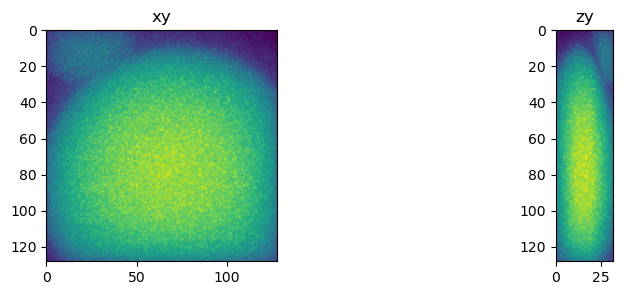

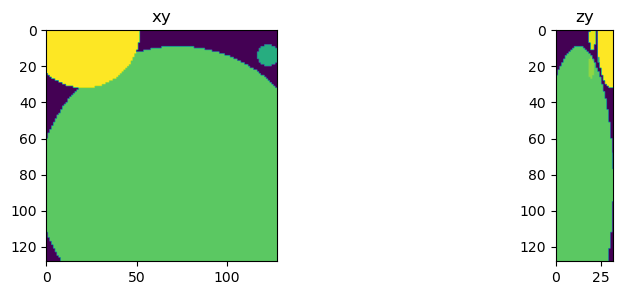

In [3]:
dl_path = r'../../models'

'''
data_path1 = os.path.join(dl_path, 'spheres_big_noise_high_na_high', 'train')
data_path2 = os.path.join(dl_path, 'spheres_big_noise_low_na_high', 'train')
data_path3 = os.path.join(dl_path, 'spheres_small_noise_high_na_high', 'train')
data_path4 = os.path.join(dl_path, 'spheres_small_noise_low_na_high', 'train')
paths = [data_path1, data_path2, data_path3, data_path4]
'''

data_path1 = os.path.join(dl_path, 'spheres_big_small_noise_high_na_high', 'train')

paths = [data_path1]

X = []
Y = []

for path in paths:
    X_, Y_ = collect_training_data(path, sub_sample=1, downsample=False, normalize_truth=True)
    print(path)
    print(len(X_))
    print()
    X.extend(X_)
    Y.extend(Y_)

print(len(X))
print(len(Y))

fig = show_xy_zy_max(X[0])
fig = show_xy_zy_max(Y[0])

## Shuffle the datasets

25
25


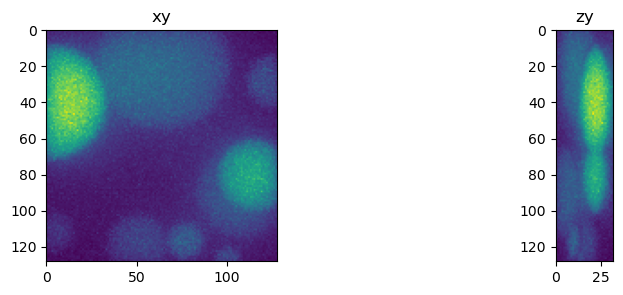

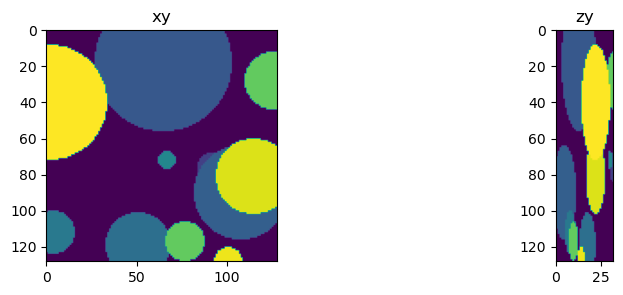

In [4]:
import random
# Combine X and Y into a single list of tuples
combined = list(zip(X, Y))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list back into X and Y
X, Y = zip(*combined)
X = list(X)
Y = list(Y)

print(len(X))
print(len(Y))

fig = show_xy_zy_max(X[10])
fig = show_xy_zy_max(Y[10])

X = np.array(X)
Y = np.array(Y)

# Import CARE

... and setup the Config for the model

In [6]:
from csbdeep.models import Config, CARE

n_channel_in =1
n_channel_out = 1
axes = 'ZYX'

# create a CARE config
# we mostly use the default settings except in this case unet_n_depth=4, so we downsampling 4 times and can use low level features
# (consider changing the number of filters (unet_n_first) to save memory)
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=20, train_epochs=50, unet_n_depth=4)
print(config)
vars(config)

Config(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=1, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=True, unet_n_depth=4, unet_kern_size=3, unet_n_first=32, unet_last_activation='linear', unet_input_shape=(None, None, None, 1), train_loss='mae', train_epochs=50, train_steps_per_epoch=20, train_learning_rate=0.0004, train_batch_size=16, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0})


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 4,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 50,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

# Create the CARE model

In [7]:
model = CARE(config, 'big_small_noisy_notnoisy_model_2', basedir=dl_path)


c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\csbdeep\models\base_model.py:149: UserWarning: output path for model already exists, files may be overwritten: C:\Users\bnort\work\ImageJ2022\tnia\deconvolution-gpu-dl-course\models\big_small_noisy_notnoisy_model_2
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


(32, 128, 128, 1) (32, 128, 128)
(15, 32, 128, 128, 1) (15, 32, 128, 128)
(10, 32, 128, 128, 1) (10, 32, 128, 128)



# Divide the training set into training and validation sets

In [ ]:

X_train=X[10:]
Y_train=Y[10:]
X_val=X[:10]
Y_val=Y[:10]

print(X[0].shape, Y[0].shape)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

# Train the model

In [8]:
model.train(X_train,Y_train, validation_data=(X_val,Y_val), epochs=50)

Epoch 1/50
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000002569C624820>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000002569C624820>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.

## Make and plot a prediction

1/1 [==============================] - 0s 261ms/step
(16, 128, 128, 1)
1.3801262 1.454539


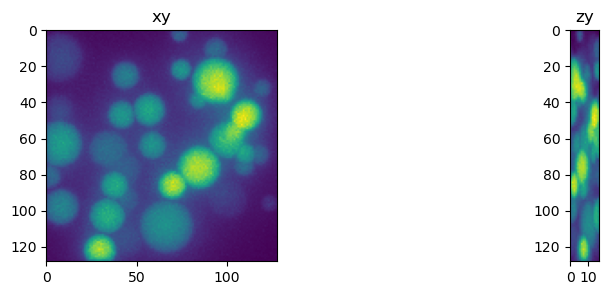

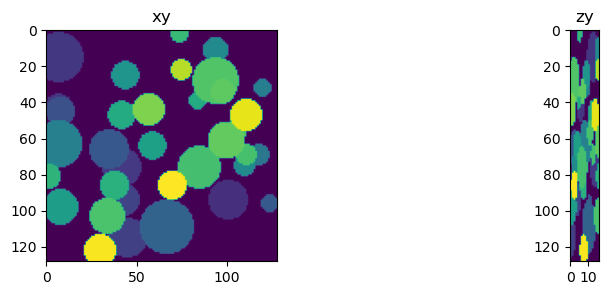

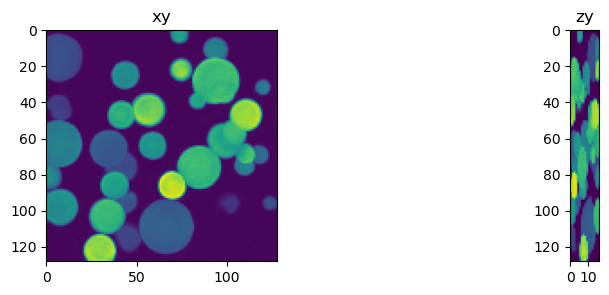

In [18]:
restored = model.predict(X_val[0], 'ZYXC')
print(restored.shape)
print(X_val[0].max(),restored.max())
fig = show_xy_zy_max(X_val[0])
fig = show_xy_zy_max(Y_val[0])
fig = show_xy_zy_max(restored)

## Visualize inputs and results in Napari

In [11]:
restored=np.squeeze(restored)
import napari
viewer = napari.Viewer()
viewer.add_image(np.squeeze(X_val[0]), name='corrupted')
viewer.add_image(np.squeeze(Y_val[0]), name='ground truth')
viewer.add_image(restored, name='restored')

napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'


<Image layer 'restored' at 0x223e80677f0>